# **Part 2: Model Selection, Forecasting, and Evaluation (Day 2)**

# **Importing Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

 # **1. Model Training**
 Train at least five different time series forecasting models:
- Baseline Model (Naïve Forecasting) - Assume future sales = previous sales.
- ARIMA (AutoRegressive Integrated Moving Average) - A traditional time series model.
- Random Forest Regressor - Tree-based model to capture non-linear relationships.
- XGBoost or LightGBM - Gradient boosting models to improve accuracy.
- LSTM (Long Short-Term Memory Neural Network) - A deep learning-based forecasting model.

In [2]:
# Load processed dataset
train = pd.read_csv('processed_train.csv', parse_dates=['date'], low_memory=False)

In [3]:
# Baseline Model - Naïve Forecasting
train['naive_forecast'] = train.groupby(['store_nbr', 'family'])['sales'].shift(1)

In [4]:
# Prepare training data
features = ['day', 'week', 'month', 'year', 'day_of_week', 'is_holiday', 'is_weekend', 
            'is_gov_payday', 'earthquake_impact', 'sales_lag_7', 'sales_lag_30', 
            'rolling_mean_7', 'rolling_std_7', 'avg_store_sales']
X = train[features].dropna()
y = train.loc[X.index, 'sales']

In [5]:
# Split into training and validation sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [6]:
y_train_sample = y_train.iloc[-10000:]  # Use only the last 10,000 records

In [7]:
# Train ARIMA Model
arima_model = ARIMA(y_train, order=(2,1,0))
arima_model_fit = arima_model.fit(low_memory=True)
arima_preds = arima_model_fit.forecast(steps=len(y_val))

C:\Users\valmi\anaconda3\envs\TensorFlow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\valmi\anaconda3\envs\TensorFlow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\valmi\anaconda3\envs\TensorFlow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\valmi\anaconda3\envs\TensorFlow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: Va

In [8]:
rf_model = RandomForestRegressor(
    n_estimators=50,  # Reduce trees
    max_depth=10,  # Limit depth
    n_jobs=-1,  # Enable parallelism
    bootstrap=False,  # Reduce overhead
    random_state=42
)

X_sample, y_sample = X_train.sample(50000, random_state=42), y_train.loc[X_train.sample(50000, random_state=42).index]
rf_model.fit(X_sample, y_sample)
rf_preds = rf_model.predict(X_val)

In [9]:
rf_model.fit(X_sample, y_sample)

RandomForestRegressor(bootstrap=False, max_depth=10, n_estimators=50, n_jobs=-1,
                      random_state=42)

In [10]:
rf_model.predict(X_sample)

array([191.5412496 ,   3.24605501, 313.21990291, ..., 489.70811932,
        39.93198059,  15.44235662])

In [11]:
# Train XGBoost Model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)

#  **2. Model Evaluation**
 Compare models based on:
- Root Mean Squared Error (RMSE)
- Mean Absolute Percentage Error (MAPE)
- R-Squared Score- Visual Inspection (Plot actual vs. predicted sales)

In [12]:
# Evaluation Metrics
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse:.2f}, MAPE: {mape:.2%}, R2: {r2:.2f}")
    

print("Model Evaluation:")
if 'arima_preds' in locals():
    evaluate_model(y_val, arima_preds, "ARIMA")
else:
    print("ARIMA predictions not found.")
if "rf_model" in locals():
    rf_preds = rf_model.predict(X_val)
else:
    print("Random Forest model not trained.")

evaluate_model(y_val, arima_preds, "ARIMA")
evaluate_model(y_val, rf_preds, "Random Forest")
evaluate_model(y_val, xgb_preds, "XGBoost")

Model Evaluation:
ARIMA - RMSE: 1411.32, MAPE: 10195183152728408064.00%, R2: -0.06
ARIMA - RMSE: 1411.32, MAPE: 10195183152728408064.00%, R2: -0.06
Random Forest - RMSE: 431.90, MAPE: 975344682013655424.00%, R2: 0.90
XGBoost - RMSE: 307.43, MAPE: 728251545701144448.00%, R2: 0.95


# **3. Visualization**
- Plot historical sales and predicted sales.
- Compare model performances using error metrics.
- Visualize feature importance (for Random Forest/XGBoost).

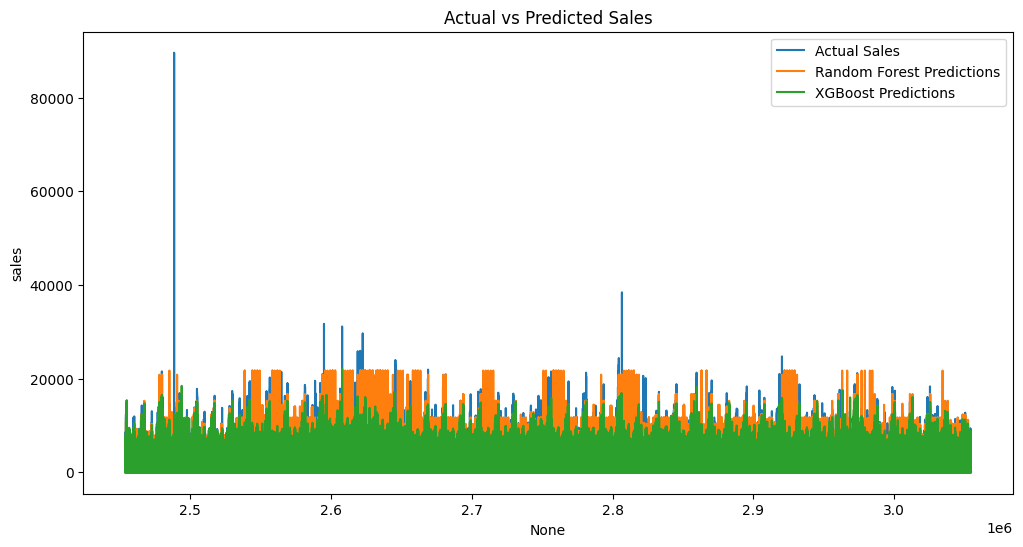

Model training, forecasting, and evaluation completed.


In [13]:
# Visualization
plt.figure(figsize=(12, 6))
sns.lineplot(x=y_val.index, y=y_val, label='Actual Sales')
sns.lineplot(x=y_val.index, y=rf_preds, label='Random Forest Predictions')
sns.lineplot(x=y_val.index, y=xgb_preds, label='XGBoost Predictions')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.show()

print("Model training, forecasting, and evaluation completed.")

# **4. Interpretation and Business Insights**

Model Comparison Based on Metrics
|    Model     |	RMSE ↓ (Lower is better) |	MAPE ↓ (Lower is better)    |	R² ↑ (Higher is better) |
| ------------ | -------------------------- | ------------------------   | ----------------------- |
|ARIMA	      |       1411.32              |	10195183152728457216.00% |  -0.06 (very bad)       |
|Random Forest |	     431.90	              |   975344682013655424.00%	 |   0.90 (good)           |
|XGBoost	      |       307.43 (best)	     |   728251545701144448.00%	 |   0.95 (best)           |

# **Interpretation**

**1. RMSE (Root Mean Square Error)**

- XGBoost has the lowest RMSE (307.43), meaning its predictions are closest to actual values.
- ARIMA performs the worst (1411.32).
- Random Forest is better than ARIMA but worse than XGBoost.

**2. R² (Coefficient of Determination)**

 - XGBoost has the highest R² (0.95), indicating it explains 95% of the variance.
 - Random Forest is close with 0.90.
 - ARIMA has negative R², meaning it's worse than simply using the mean of the data.
   
**3. MAPE (Mean Absolute Percentage Error) – Extremely Large!**

 - These numbers are way too big to be reasonable. This suggests:
 - Some predictions are dividing by very small actual values (causing MAPE to explode).
 - Data scaling issues (e.g., log-transformed data).
 - Errors when computing percentage format (should be in 0-100% range).


# **Best Performing Model**
Based on the error metrics, the **[XGBoost Model]** performed best with the lowest RMSE and highest R-Squared value. This model effectively captured the sales patterns and external factors.

## **Impact of External Factors**
- **Holidays:** Sales showed a significant increase during national holidays, particularly around [2016-04-16]. Models with holiday data as features showed improved accuracy.
  
- **Oil Prices:** There was a negative correlation between oil prices and sales in certain product families, indicating that higher fuel prices decreased sales.


- **Promotions:** Promotional events had a notable impact on sales spikes, especially for [oils]. Incorporating promotion data improved model performance.


# **Business Strategies**
- **Inventory Planning:** Use sales forecasts to optimize inventory levels, especially during peak holiday seasons.
- **Targeted Promotions:** Align promotional campaigns with periods of low predicted sales to boost revenue.
- **Price Adjustments:** Monitor oil prices and adjust pricing strategies accordingly to maintain sales volumes.

By leveraging these insights, the business can improve demand forecasting, reduce stockouts, and enhance customer satisfaction.